# OpenVINO™ benchmark app

This notebook sets up an interface to invoke the OpenVINO™ benchmark_app, which passes in randomized data to a model to test its latency and throughput. You can run it on each device available on your machine to see the tradeoffs between running the model on CPU, GPU, or NPU. 

In order to get the purest results, the benchmark_app should not be run from within a notebook, but this is just an introduction to the app. 

Of course, speed is often not the only consideration when choosing which device to deploy to. The strength of NPUs is power efficiency. Since there is currently not an API to programmatically return power usage of a device, you can use Microsoft Performance Monitor, which uses performance counters, to monitor power usage as described in the Appendix at the bottom of this notebook.

If you are running this on your own, not as part of a workshop, install packages using `requirements.txt` and run the `setup.py` script before using this notebook.

## 1. Imports

In [ ]:
import numpy as np
import openvino as ov
import gradio as gr

import bm_utils as utils

# Initialize OpenVINO Runtime.
core = ov.Core()

## 2. Learn About Available Devices
Steps 3 and 4 will use the OpenVino benchmark_app, which automatically optimizes device-specific settings for a performance hint (latency vs. throughput). However production deployment often requires custom settings, so understanding device capabilities becomes important. The following code sample, from the [Hello Query Device Sample](https://docs.openvino.ai/canonical/learn-openvino/openvino-samples/hello-query-device.html) in the OpenVINO documentation, returns all supported properties for all devices on the system.

Look in the generated report files after the benchmark_app runs in steps 3 and 4 to see what settings were used.

In [ ]:
import logging as log
import sys

def param_to_string(parameters) -> str:
    """Convert a list / tuple of parameters returned from OV to a string."""
    if isinstance(parameters, (list, tuple)):
        return ', '.join([str(x) for x in parameters])
    else:
        return str(parameters)
log.basicConfig(format='[ %(levelname)s ] %(message)s', level=log.INFO, stream=sys.stdout)
log.info('Available devices:')
for device in core.available_devices:
        log.info(f'{device} :')
        log.info('\tSUPPORTED_PROPERTIES:')
        for property_key in core.get_property(device, 'SUPPORTED_PROPERTIES'):
            if property_key not in ('SUPPORTED_PROPERTIES'):
                try:
                    property_val = core.get_property(device, property_key)
                except TypeError:
                    property_val = 'UNSUPPORTED TYPE'
                log.info(f'\t\t{property_key}: {param_to_string(property_val)}')
        log.info('')

for handler in log.root.handlers[:]:
    log.root.removeHandler(handler)

## 3. Benchmark Latency

Choose a model-precision, select a device to run on, and click Submit.

This runs the benchmark_app for the selected model on the selected device, using `-hint latency`, for 30 seconds of inference using random input data. For example:

`benchmark_app -m models/mobilenet-v2/public/mobilenet-v2-pytorch/FP32/mobilenet-v2-pytorch.xml -hint latency -infer_precision f32 -d CPU -t 30`

It will plot the median latency for each device/precision combination for that model. Each model will have its own graph - you can switch between models and back, and the data will persist until you click the Clear Plot Data button. You can view the full report output in the reports directory, named _model-precision-device_.txt.

With `-d AUTO`, OpenVINO checks the precision of the model, and deploys to the first device on the priority list that's capable of supporting that precision. The default priority list, with supported precisions, can be found in the [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/auto-device-selection.html). There is also information there on how to customize the priority order, and how to exclude devices. The default ordering (as of 2024.3) is as follows:

1. dGPU (discrete GPU)
2. iGPU (integrated GPU)
3. CPU

Note that NPU is not automatically included in the prioritized list as of 2024.3. To include NPU, explicitly add it to the prioritized AUTO list, for example `-d AUTO:GPU,NPU,CPU`

In [ ]:
latency_demo = utils.build_gr_blocks(core.available_devices, goal="Latency")   
latency_demo.launch()

## 4. Benchmark Throughput
Choose a model-precision, select a device to run on, and click Submit.

This runs the benchmark_app for the selected model on the selected device, using `-hint throughput`, for 30 seconds of inference using random input data. For example:

`benchmark_app -m models/unet-camvid/intel/unet-camvid-onnx-0001/FP16/unet-camvid-onnx-0001.xml -hint throughput -infer_precision f16 -d GPU -t 30`

It will plot the throughput, in FPS, for each device/precision combination for that model. Each model will have its own graph - you can switch between models and back, and the data will persist until you click the Clear Plot Data button. You can view the full report output in the reports directory, _model-precision-device_.txt. Notice that in Step 8 of the report, it shows the runtime parameters for each device that it set based on the model and performance hint.

In this exercise, when we use AUTO device selection, we modify the hint to use "cumulative throughput" and to make sure the NPU is included in AUTO. These are the modified args: `-hint cumulative_throughput -d AUTO:GPU,NPU,CPU`. This loads the network model to all available devices, then runs inference on them all in parallel based on the specified priority.

In [ ]:
throughput_demo = utils.build_gr_blocks(core.available_devices, goal="Throughput")   
throughput_demo.launch()

## Further study: LLM/GenAI benchmarking

Generative AI models operate differently from traditional inference models, and performance is measured differently. For instance, LLM performance will vary depending on the number of input tokens, and the key measurements are time-to-first-token (TTFT) latency, time-per-output-token (TPOT) latency and tokens/second throughput for all the subsequent tokens.

The [OpenVINO™ GenAI repository](https://github.com/openvinotoolkit/openvino.genai) has a benchmark tool specifically for LLMs. The benchmark tool is located in [https://github.com/openvinotoolkit/openvino.genai/tree/master/llm_bench/python](https://github.com/openvinotoolkit/openvino.genai/tree/master/llm_bench/python). A typical invocation of this script for might look like:

`python benchmark.py -m models/llama-2-7b-chat/pytorch/dldt/FP32 -p "What is openvino?" -n 2`

Note that this passes in an actual prompt. Since performance will vary depending on prompt length, you can use the `-pf` option to pass in a JSON file with a list of prompts to test. It's a good idea to set the `-n <number_of_iterations>` option to be greater than 1, allowing for the first iteration to be a warmup to ensure subsequent iterations have higher cache hit rates.

## Appendix: Using Microsoft Performance Monitor to track power consumption

1. Open the app. Go to the start menu, and type "performance monitor". It should be installed already, open it.

   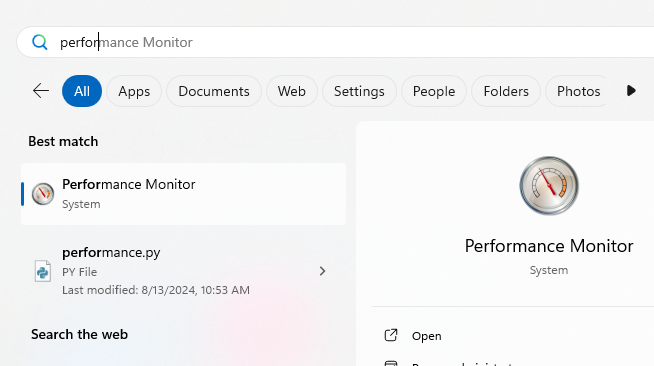
   
3. Select "Performance Monitor" as shown below, then click the green + to add a counter
   
   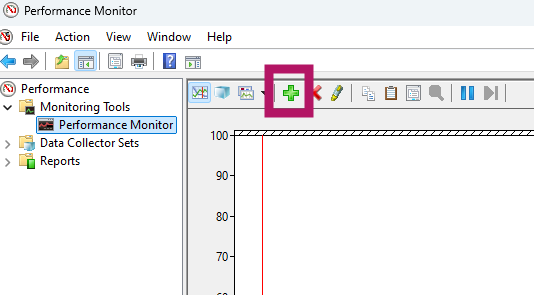
   
4. Double-click "Energy Meter", select "Energy" and "Power", select "RAPL_Package0_PKG" for instances, click "Add", then click "OK".
   
   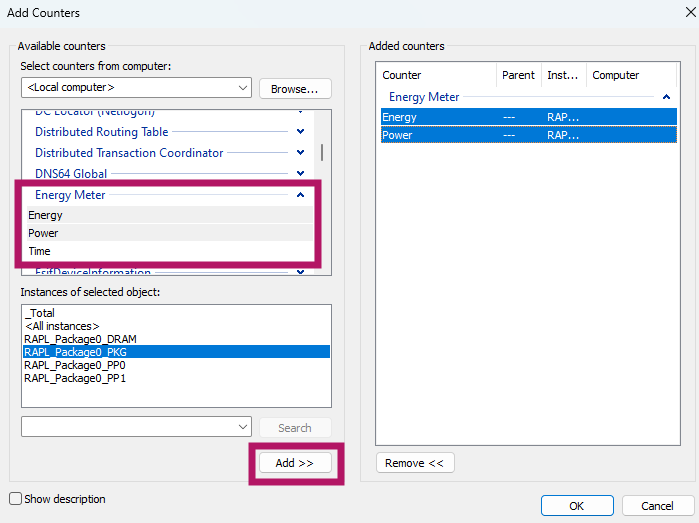
   
6. Set the Y axis.
   First determine the range, by graph type (Ctrl-G or the button below) from a line graph to a report. Take note of the value for Power. Kick off a benchmark_app run and again take note of the value of Power.
   
   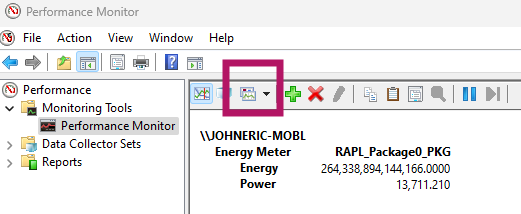
   
   Toggle back to the line graph. Right click on the y axis and bring up "Properties...", then the "Graph" tab, and set a value higher than what you estimate the max would be, for instance:
   
   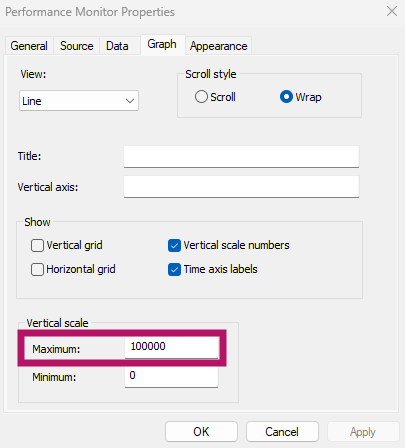
   
8. Monitor usage over time while you invoke different benchmark_app runs.